In [1]:
import xarray as xr

# Path to the NetCDF file
file_path = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc'

# Load the NetCDF file with decode_times set to False
dataset = xr.open_dataset(file_path, decode_times=False)


dataset

/home/yan481/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yan481/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<xarray.Dataset> Size: 10GB
Dimensions:  (phalf: 41, time: 1440, lon: 128, lonb: 129, lat: 64, latb: 65,
              pfull: 40)
Coordinates:
  * phalf    (phalf) float32 164B 0.0 0.4844 0.6312 0.8205 ... 863.5 941.4 1e+03
  * time     (time) float64 12kB 8.64e+03 8.64e+03 8.641e+03 ... 9e+03 9e+03
  * lon      (lon) float32 512B 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lonb     (lonb) float32 516B -1.406 1.406 4.219 7.031 ... 353.0 355.8 358.6
  * lat      (lat) float32 256B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * latb     (latb) float32 260B -90.0 -86.58 -83.76 -80.96 ... 83.76 86.58 90.0
  * pfull    (pfull) float32 160B 0.1782 0.5562 0.7238 ... 821.4 902.2 970.5
Data variables:
    bk       (phalf) float32 164B ...
    pk       (phalf) float32 164B ...
    ps       (time, lat, lon) float32 47MB ...
    ucomp    (time, pfull, lat, lon) float32 2GB ...
    vcomp    (time, pfull, lat, lon) float32 2GB ...
    temp     (time, pfull, lat, lon) float32 2GB ...
    sphum    (time, pfull, lat, lon) float32 2GB ...
    omega    (time, pfull, lat, lon) float32 2GB ...
    precip   (time, lat, lon) float32 47MB ...
    evap     (time, lat, lon) float32 47MB ...
    t_surf   (time, lat, lon) float32 47MB ...
Attributes:
    filename:  atmos_4xdaily.nc
    title:     MiMA

In [2]:
# Access the 'vcomp' variable
ucomp_data = dataset['ucomp']

# Print all values of the 'vcomp' variable
ucomp_data

<xarray.DataArray 'ucomp' (time: 1440, pfull: 40, lat: 64, lon: 128)> Size: 2GB
[471859200 values with dtype=float32]
Coordinates:
  * time     (time) float64 12kB 8.64e+03 8.64e+03 8.641e+03 ... 9e+03 9e+03
  * lon      (lon) float32 512B 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lat      (lat) float32 256B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * pfull    (pfull) float32 160B 0.1782 0.5562 0.7238 ... 821.4 902.2 970.5
Attributes:
    long_name:      zonal wind component
    units:          m/sec
    valid_range:    [-400.  400.]
    cell_methods:   time: point
    standard_name:  none

In [3]:
tau = dataset['time'][-1].values - dataset['time'][0].values
print(tau)

359.75


$$
\Psi_p(p, \phi)=\frac{1}{\tau} \int_0^\tau \int_0^{2 \pi} \int_p^{p_{\text s{uff }}} v a \cos \phi \frac{d p}{g} d \lambda d t
$$

Calculating Streamfunction for atmos_4xdaily.nc: 100%|██████████| 40/40 [01:30<00:00,  2.25s/it]


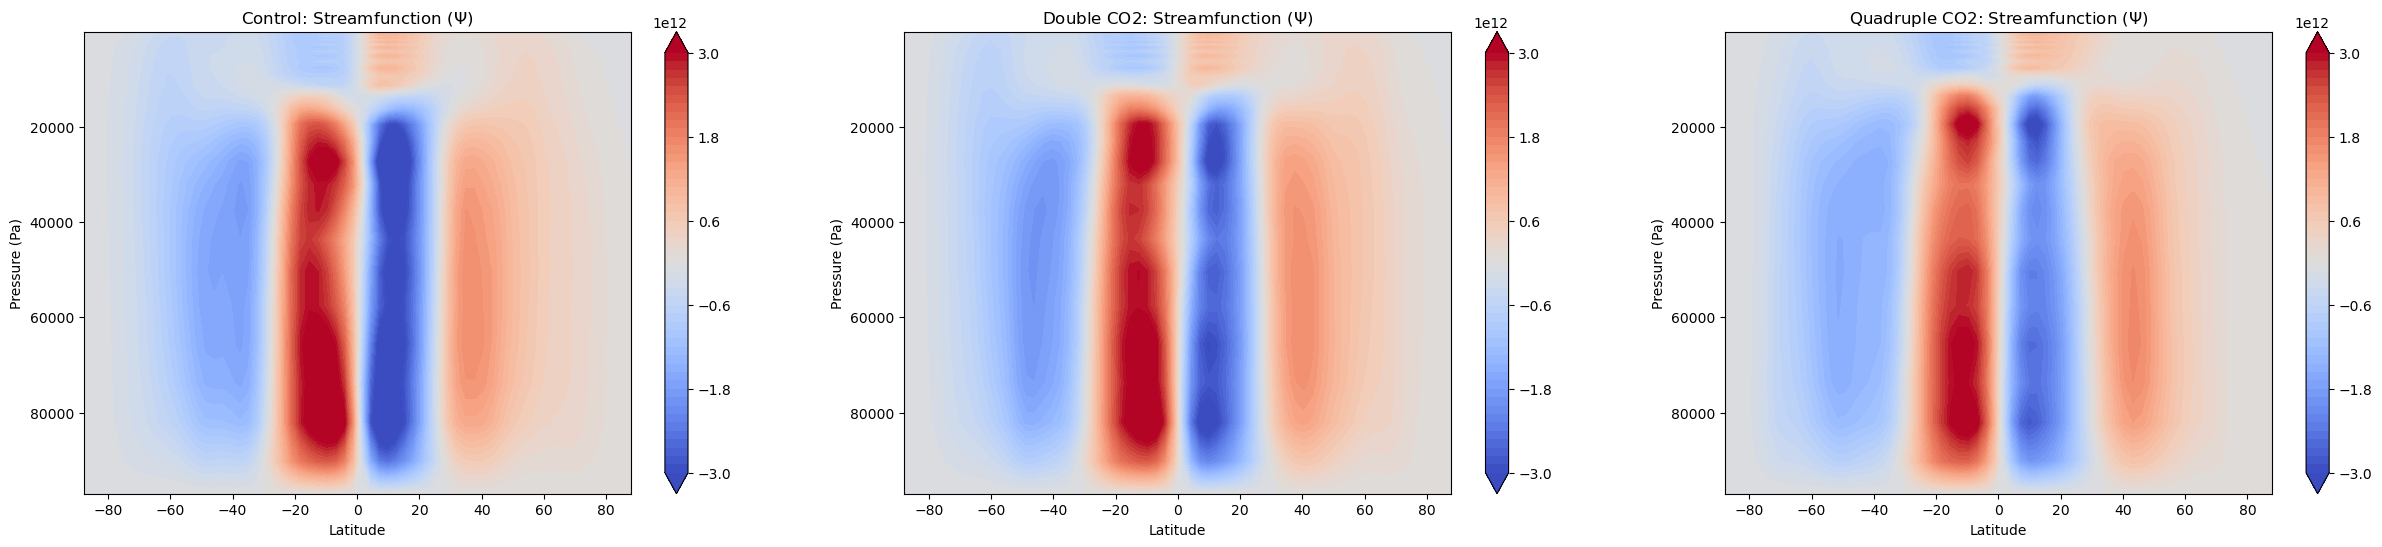

In [4]:
import xarray as xr
import numpy as np
import scipy.integrate
from tqdm import tqdm 
import matplotlib.pyplot as plt
import os

a = 6371000  # Earth's radius in meters
g = 9.81     # Acceleration due to gravity in m/s^2

# Function to calculate streamfunction
def calculate_psi(file_path):
    # Load the NetCDF file with decode_times set to False
    dataset = xr.open_dataset(file_path, decode_times=False)
    
    # Access the 'vcomp' variable
    vcomp = dataset['vcomp']
    
    # Coordinates
    press = dataset['pfull'].values * 100 # Pressure levels
    lat = dataset['lat'].values      # Latitude
    lon = dataset['lon'].values      # Longitude
    time = dataset['time'].values    # Time points
    tau = dataset['time'][-1].values - dataset['time'][0].values
    
    # Initialize the streamfunction array
    psi = np.zeros((len(press), len(lat)))
    
    # Calculate the streamfunction
    for i in tqdm(range(len(press)), desc=f'Calculating Streamfunction for {os.path.basename(file_path)}'):
        p = press[i]
        # Integrate over the vertical, longitude, and time dimensions
        temp = scipy.integrate.simps(vcomp[:, i:, :, :], press[i:], axis=1)
        temp_u = scipy.integrate.simps(temp, lon, axis=2)
        temp_u_u = scipy.integrate.simps(temp_u, time, axis=0)
        temp_u_u_u = temp_u_u * np.cos(np.deg2rad(lat))
        psi[i, :] = temp_u_u_u * a / g / tau

    return psi, press, lat

# Paths to the NetCDF files
file_path1 = '/scratch/negishi/yan481/3004/control/25/atmos_4xdaily.nc' # Control Yr 25
file_path2 = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc' # Double Yr 25
file_path3 = '/scratch/negishi/yan481/3004/quadruple/25/atmos_4xdaily.nc' # Quadruple Yr 25

# Calculate psi for each year
psi1, press1, lat1 = calculate_psi(file_path1)
psi2, press2, lat2 = calculate_psi(file_path2)
psi3, press3, lat3 = calculate_psi(file_path3)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))


# Define color range and levels for consistency across plots
vmin, vmax = -3e12, 3e12
levels = np.linspace(vmin, vmax, 51)  # Create 50 intervals within the specified range

X1, Y1 = np.meshgrid(lat1, press1)
cp1 = ax1.contourf(X1, Y1, psi1, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp1, ax=ax1, ticks=np.linspace(vmin, vmax, 6))  # Add colorbar with ticks at regular intervals
ax1.set_title(r'Control: Streamfunction ($\Psi$)')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Pressure (Pa)')
ax1.invert_yaxis()

X2, Y2 = np.meshgrid(lat2, press2)
cp2 = ax2.contourf(X2, Y2, psi2, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp2, ax=ax2, ticks=np.linspace(vmin, vmax, 6))  # Ensure same colorbar for second plot
ax2.set_title(r'Double CO2: Streamfunction ($\Psi$)')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Pressure (Pa)')
ax2.invert_yaxis()

X3, Y3 = np.meshgrid(lat3, press3)
cp3 = ax3.contourf(X3, Y3, psi3, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp3, ax=ax3, ticks=np.linspace(vmin, vmax, 6))  # Ensure same colorbar for second plot
ax3.set_title(r'Quadruple CO2: Streamfunction ($\Psi$)')
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Pressure (Pa)')
ax3.invert_yaxis()

plt.show()


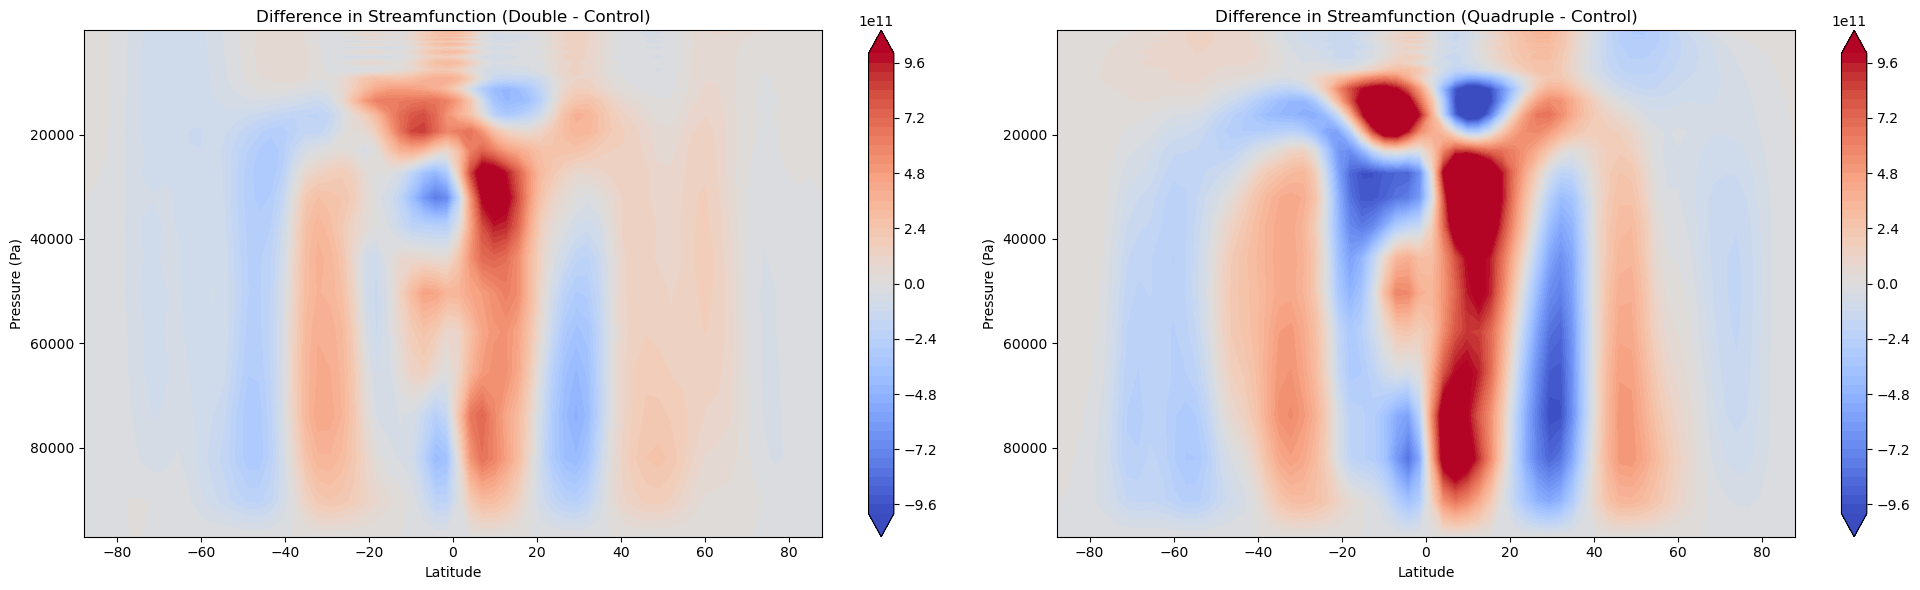

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the differences between the streamfunctions
psi_diff1 = psi2 - psi1
psi_diff2 = psi3 - psi1

vmin, vmax = -1e12, 1e12
levels = np.linspace(vmin, vmax, 51)  # Create 50 intervals within the specified range

# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 6))  # Adjust figure size to accommodate two subplots

# Subplot 1: psi2 - psi1
X, Y = np.meshgrid(lat1, press1)  # Assuming the coordinates are the same
cp1 = ax[0].contourf(X, Y, psi_diff1, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp1, ax=ax[0])
ax[0].set_title('Difference in Streamfunction (Double - Control)')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Pressure (Pa)')
ax[0].invert_yaxis()  # Invert the y-axis

# Subplot 2: psi3 - psi1
cp2 = ax[1].contourf(X, Y, psi_diff2, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp2, ax=ax[1])
ax[1].set_title('Difference in Streamfunction (Quadruple - Control)')
ax[1].set_xlabel('Latitude')
ax[1].set_ylabel('Pressure (Pa)')
ax[1].invert_yaxis()  # Invert the y-axis

plt.tight_layout()  # Adjust layout so that plots do not overlap
plt.show()


$$
\begin{aligned}
& \Psi_\theta\left(\theta_0, \phi\right)=\frac{1}{\tau} \int_0^\tau \int_0^{2 \pi} \int_0^{p_{\text {surf }}} H\left(\theta_0-\theta\right) v a \cos \phi \frac{d p}{g} d \lambda d t
\end{aligned}
$$

$$
\theta=\left(\frac{p_0}{p}\right)^{\frac{R}{C_{\mathrm{p}}}} T
$$

Theta_0 calculations: 41it [03:29,  5.11s/it]
Theta_0 calculations: 41it [03:31,  5.15s/it]
Theta_0 calculations: 41it [03:29,  5.11s/it]


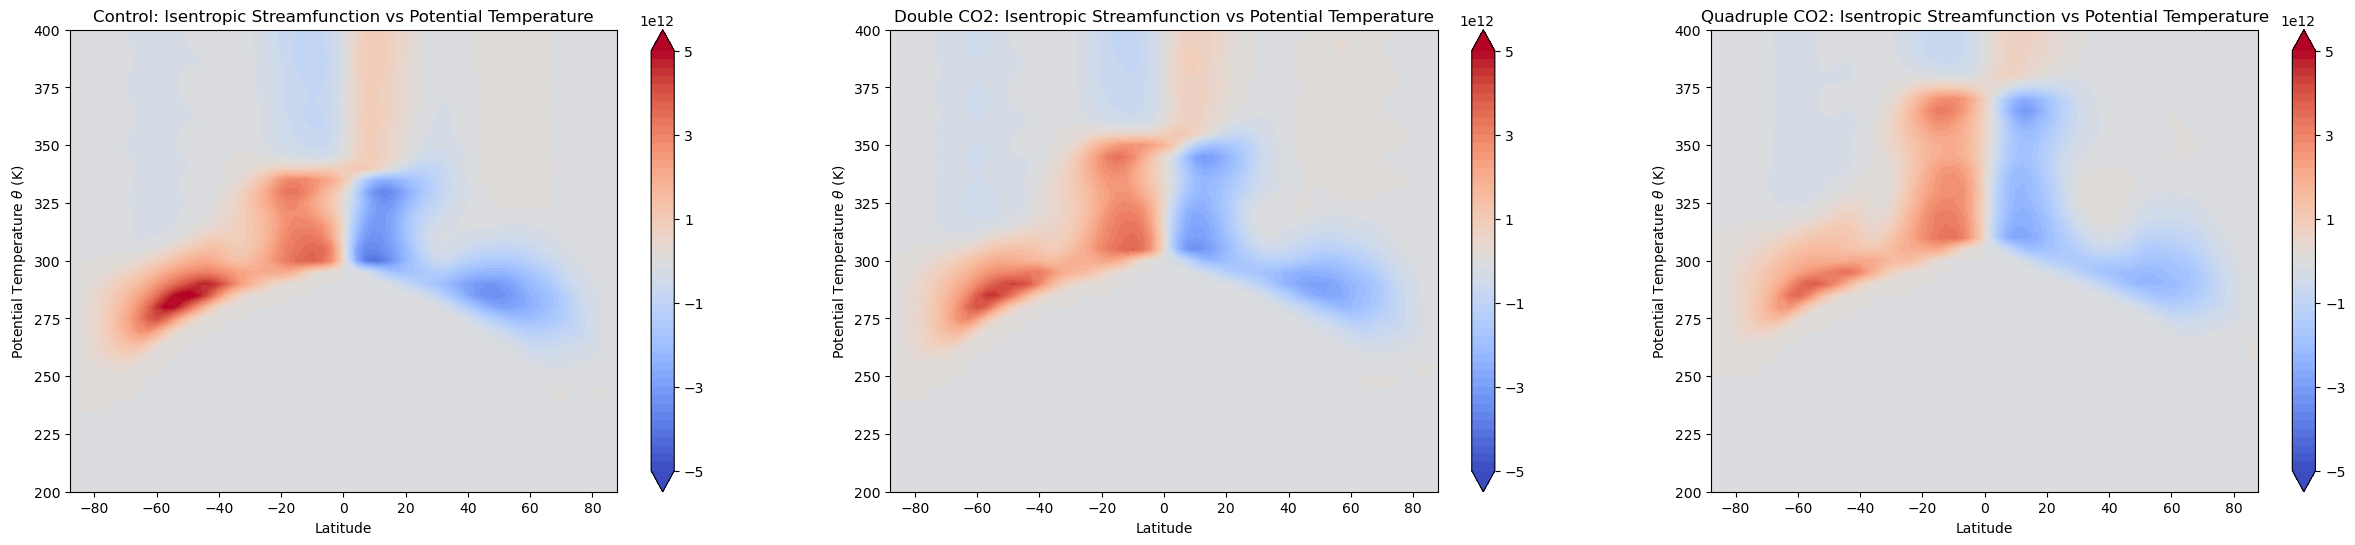

In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import os
import glob
import scipy.integrate

# Constants
a = 6.371e6  # Earth's radius in meters
g = 9.81     # Acceleration due to gravity in m/s^2
R = 287.05   # Gas constant for dry air
Cp = 1004    # Specific heat at constant pressure for dry air
p0 = 1000    # Reference pressure in hPa

# Function to calculate the isentropic streamfunction
def calculate_psi(file_path):
    # Load the NetCDF file with decode_times set to False
    dataset = xr.open_dataset(file_path, decode_times=False)
    
    # Access variables
    vcomp = dataset['vcomp']
    ta = dataset['temp']
    
    # Calculate potential temperature
    theta = ta * (p0 / vcomp['pfull']) ** (R / Cp)
    
    # Coordinates
    time = dataset['time'].values    # Time points
    tau = dataset['time'][-1].values - dataset['time'][0].values
    
    # Compute streamfunction across latitude and theta_0 levels
    theta_0_range = np.linspace(200, 400, 41)
    psi = xr.DataArray(np.zeros((len(theta_0_range), len(ta.lat))),
                       dims=["theta_0", "lat"],
                       coords={"theta_0": theta_0_range, "lat": ta.lat})
    
    with ProgressBar():
        for idx, theta_0 in tqdm(enumerate(theta_0_range), desc='Theta_0 calculations'):
            # Apply Heaviside function to filter temperature fields
            H = xr.where(theta_0 >= theta, 1, 0)
            v_masked = vcomp * H
        
            # Integrate using Xarray across pressure levels, longitude, and time
            temp_theta = v_masked.integrate('pfull').integrate('lon').mean('time')   ### convert to 2pi, convert from hPa to Pa
            temp_cos = temp_theta * np.cos(np.deg2rad(ta.lat)) * 100
            psi[idx, :] = temp_cos * a / g
        
        # Trigger the computation
        psi = psi.compute()
    return psi, ta.lat.values, theta_0_range

# Paths to the NetCDF files
file_path1 = '/scratch/negishi/yan481/3004/control/25/atmos_4xdaily.nc' # Control Yr 25
file_path2 = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc' # Double Yr 25
file_path3 = '/scratch/negishi/yan481/3004/quadruple/25/atmos_4xdaily.nc' # Quadruple Yr 25

# Calculate psi for each year
psi1, lat1, theta_0_range1 = calculate_psi(file_path1)
psi2, lat2, theta_0_range2 = calculate_psi(file_path2)
psi3, lat3, theta_0_range3 = calculate_psi(file_path3)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

# Define color range and levels for consistency across plots
vmin, vmax = -5e12, 5e12
levels = np.linspace(vmin, vmax, 51)  # Create 50 intervals within the specified range

X1, Y1 = np.meshgrid(lat1, theta_0_range1)
cp1 = ax1.contourf(X1, Y1, psi1, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp1, ax=ax1, ticks=np.linspace(vmin, vmax, 6))  # Add colorbar with ticks at regular intervals
ax1.set_title('Control: Isentropic Streamfunction vs Potential Temperature')
ax1.set_xlabel('Latitude')
ax1.set_ylabel(r'Potential Temperature $\theta$ (K)')

X2, Y2 = np.meshgrid(lat2, theta_0_range2)
cp2 = ax2.contourf(X2, Y2, psi2, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp2, ax=ax2, ticks=np.linspace(vmin, vmax, 6))  # Ensure same colorbar for second plot
ax2.set_title('Double CO2: Isentropic Streamfunction vs Potential Temperature')
ax2.set_xlabel('Latitude')
ax2.set_ylabel(r'Potential Temperature $\theta$ (K)')

X3, Y3 = np.meshgrid(lat3, theta_0_range3)
cp3 = ax3.contourf(X3, Y3, psi3, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp3, ax=ax3, ticks=np.linspace(vmin, vmax, 6))  # Ensure same colorbar for second plot
ax3.set_title('Quadruple CO2: Isentropic Streamfunction vs Potential Temperature')
ax3.set_xlabel('Latitude')
ax3.set_ylabel(r'Potential Temperature $\theta$ (K)')

plt.show()



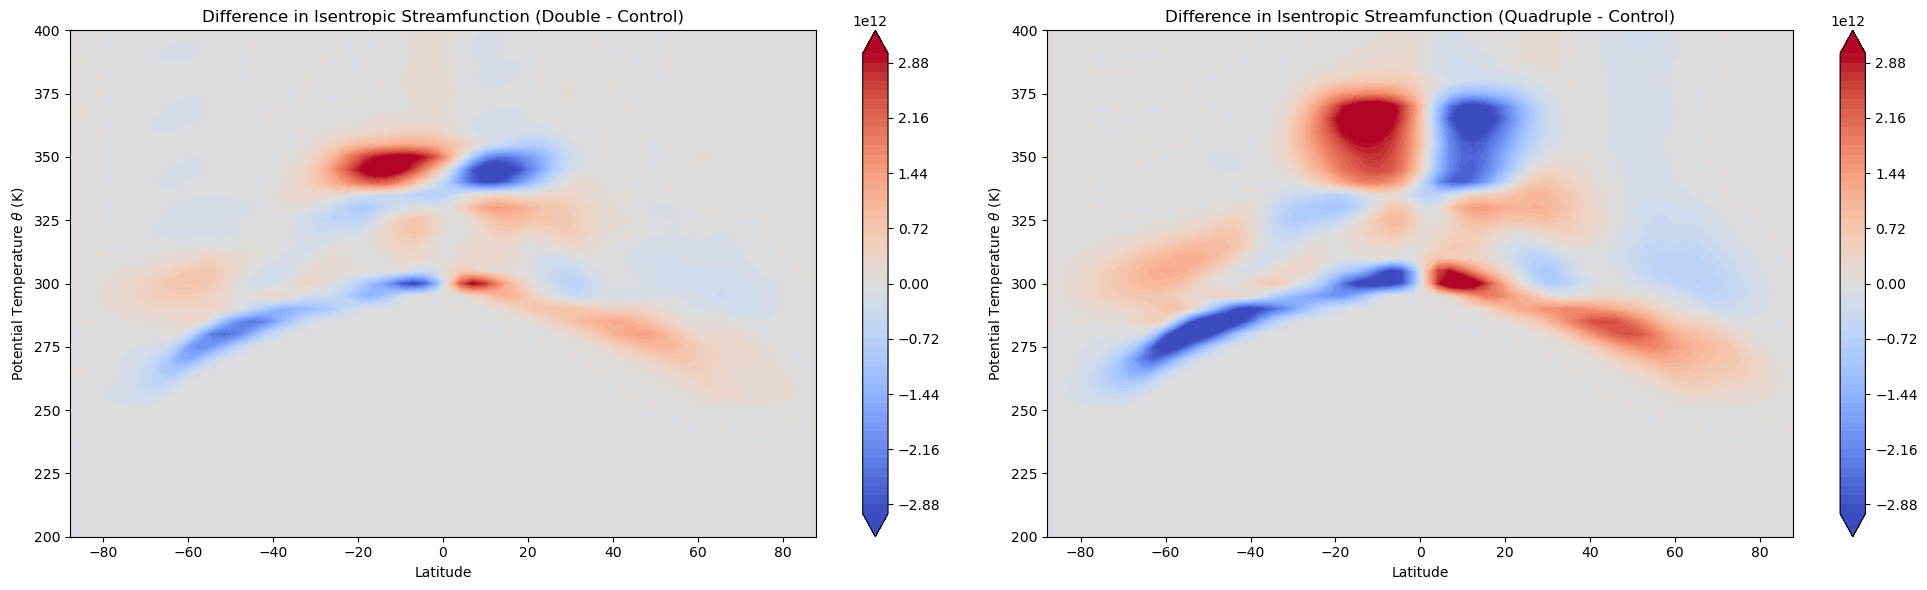

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming psi1, psi2, psi3, lat1, theta_0_range1 are already defined from the previous computation

# Compute the differences between the streamfunctions
psi_diff1 = psi2 - psi1
psi_diff2 = psi3 - psi1

vmin, vmax = -3e12, 3e12
levels = np.linspace(vmin, vmax, 51)  # Create 50 intervals within the specified range

# Create a figure with 2 subplots
plt.figure(figsize=(20, 6))  # Adjust figure size to accommodate two subplots

# Subplot 1: psi2 - psi1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
X, Y = np.meshgrid(lat1, theta_0_range1)  # Assuming the coordinates are the same
cp1 = plt.contourf(X, Y, psi_diff1, levels=levels, cmap='coolwarm', extend='both')
plt.colorbar(cp1)
plt.title('Difference in Isentropic Streamfunction (Double - Control)')
plt.xlabel('Latitude')
plt.ylabel(r'Potential Temperature $\theta$ (K)')

# Subplot 2: psi3 - psi1
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
cp2 = plt.contourf(X, Y, psi_diff2, levels=levels, cmap='coolwarm', extend='both')
plt.colorbar(cp2)
plt.title('Difference in Isentropic Streamfunction (Quadruple - Control)')
plt.xlabel('Latitude')
plt.ylabel(r'Potential Temperature $\theta$ (K)')

plt.tight_layout()  # Adjust layout so that plots do not overlap
plt.show()


 ### Zonal Wind

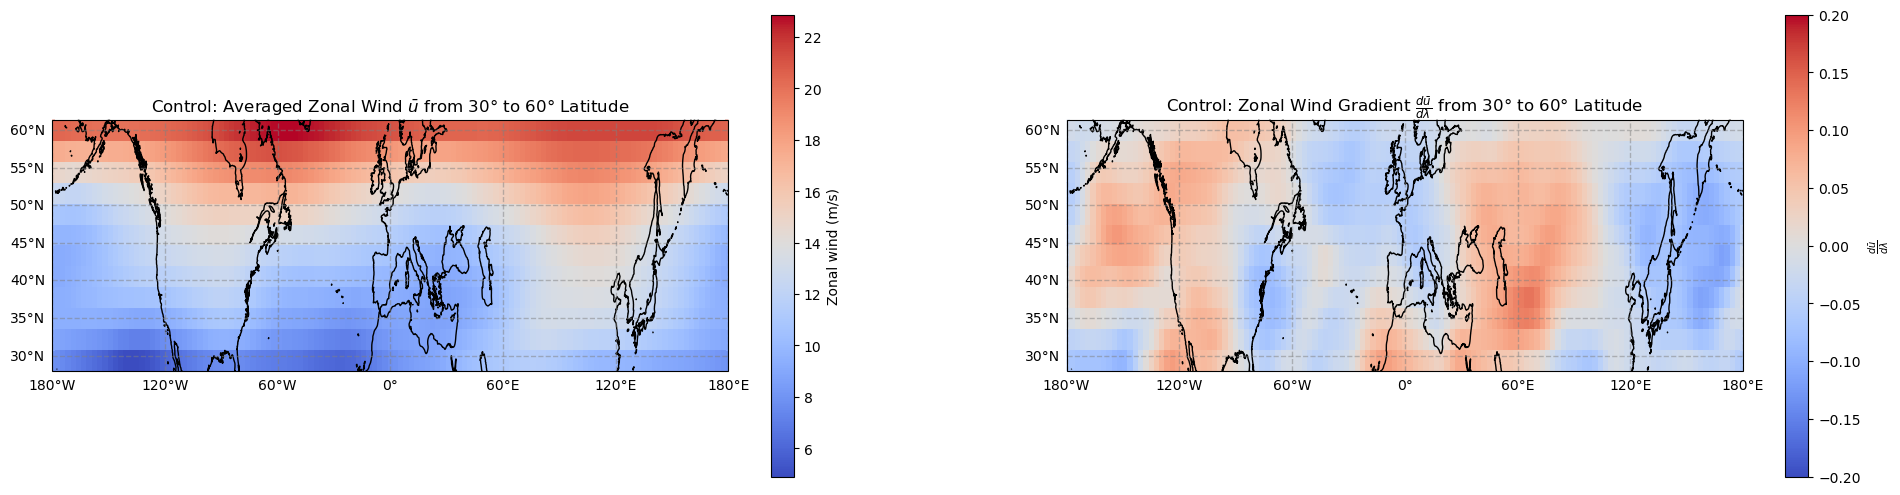

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Path to the NetCDF file
file_path = '/scratch/negishi/yan481/3004/control/25/atmos_4xdaily.nc' # COntrol Yr 25

# Load the NetCDF file with decode_times set to False
dataset = xr.open_dataset(file_path, decode_times=False)

# Select the 'ucomp' variable
ucomp = dataset['ucomp']

# Filter for latitudes between 29.3 and 60 degrees
filtered_ucomp = ucomp.where((ucomp.lat >= 29.3) & (ucomp.lat <= 60), drop=True)

# Compute the time average of the filtered ucomp
time_avg_ucomp = filtered_ucomp.mean(dim='time').mean(dim='pfull')

# Wrapping around for circular boundary condition at the 0th/360th meridian
wrapped_ucomp = xr.concat([time_avg_ucomp, time_avg_ucomp.isel(lon=0)], dim='lon')

# Calculate du/dlon considering the wrap
delta_lon = np.diff(wrapped_ucomp.lon)[0]  # Assuming uniform spacing
du_dlon = wrapped_ucomp.diff(dim='lon') / delta_lon

# Determine the maximum absolute value for symmetric coloring around zero
# max_dudlon = np.abs(du_dlon.values).max()
max_dudlon = 0.2

# Set up the plot with a map projection
fig, ax = plt.subplots(1, 2, figsize=(24, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# First subplot for time-averaged ucomp
ax[0].coastlines()
lons, lats = np.meshgrid(time_avg_ucomp.lon.values, time_avg_ucomp.lat.values)
heatmap1 = ax[0].pcolormesh(lons, lats, time_avg_ucomp.values, transform=ccrs.PlateCarree(), cmap='coolwarm')
plt.colorbar(heatmap1, ax=ax[0], orientation='vertical', label='Zonal wind (m/s)')
ax[0].set_title(r'Control: Averaged Zonal Wind $\bar{u}$ from 30° to 60° Latitude')
ax[0].set_aspect(4) 

# Second subplot for du/dlon
ax[1].coastlines()
# Create a new meshgrid for the gradient which matches the new dimensions
lons_gradient, lats_gradient = np.meshgrid(time_avg_ucomp.lon.values[:], time_avg_ucomp.lat.values)
heatmap2 = ax[1].pcolormesh(lons_gradient, lats_gradient, du_dlon.values, vmin=-max_dudlon, vmax=max_dudlon,
                            transform=ccrs.PlateCarree(), cmap='coolwarm')
plt.colorbar(heatmap2, ax=ax[1], orientation='vertical', label=r'$\frac{d\bar{u}}{d\lambda}$')
ax[1].set_title(r'Control: Zonal Wind Gradient $\frac{d\bar{u}}{d\lambda}$ from 30° to 60° Latitude')
ax[1].set_aspect(4) 

for axis in ax:
    gl = axis.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

plt.show()


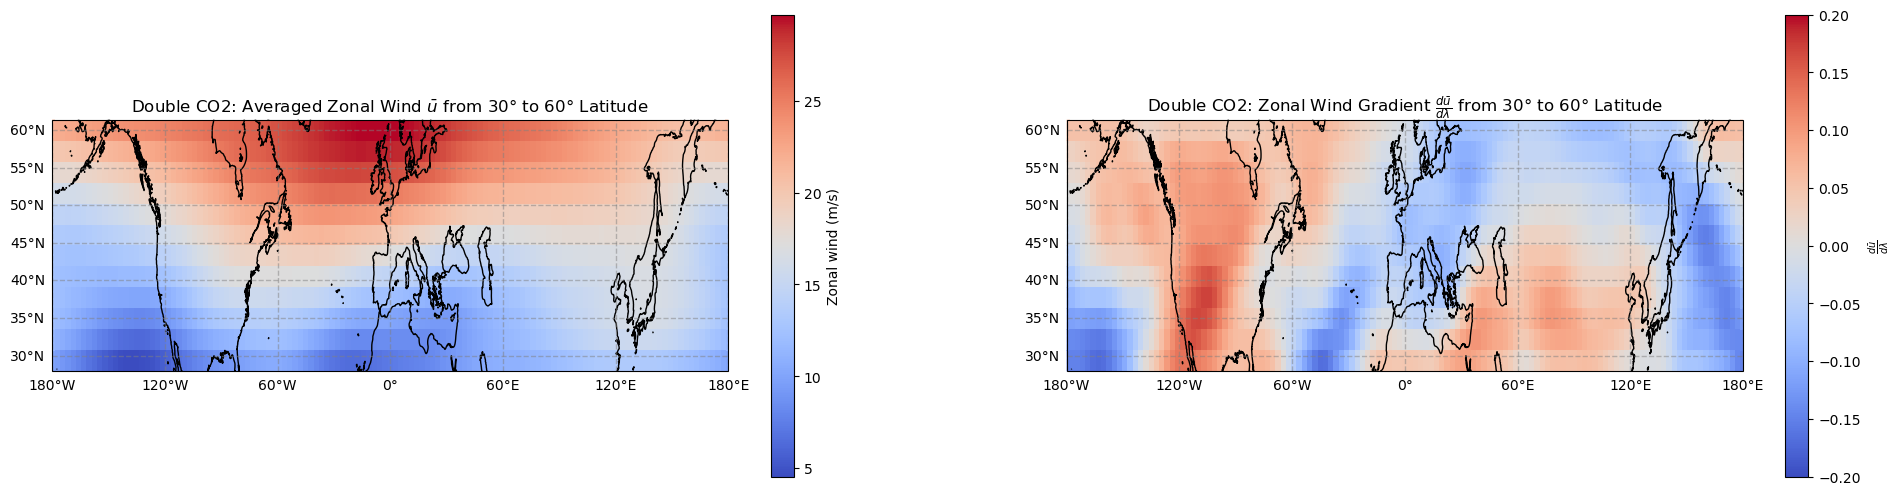

In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Path to the NetCDF file
file_path = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc'

# Load the NetCDF file with decode_times set to False
dataset = xr.open_dataset(file_path, decode_times=False)

# Select the 'ucomp' variable
ucomp = dataset['ucomp']

# Filter for latitudes between 29.3 and 60 degrees
filtered_ucomp = ucomp.where((ucomp.lat >= 29.3) & (ucomp.lat <= 60), drop=True)

# Compute the time average of the filtered ucomp
time_avg_ucomp = filtered_ucomp.mean(dim='time').mean(dim='pfull')

# Wrapping around for circular boundary condition at the 0th/360th meridian
wrapped_ucomp = xr.concat([time_avg_ucomp, time_avg_ucomp.isel(lon=0)], dim='lon')

# Calculate du/dlon considering the wrap
delta_lon = np.diff(wrapped_ucomp.lon)[0]  # Assuming uniform spacing
du_dlon = wrapped_ucomp.diff(dim='lon') / delta_lon

# Determine the maximum absolute value for symmetric coloring around zero
# max_dudlon = np.abs(du_dlon.values).max()
max_dudlon = 0.2

# Set up the plot with a map projection
fig, ax = plt.subplots(1, 2, figsize=(24, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# First subplot for time-averaged ucomp
ax[0].coastlines()
lons, lats = np.meshgrid(time_avg_ucomp.lon.values, time_avg_ucomp.lat.values)
heatmap1 = ax[0].pcolormesh(lons, lats, time_avg_ucomp.values, transform=ccrs.PlateCarree(), cmap='coolwarm')
plt.colorbar(heatmap1, ax=ax[0], orientation='vertical', label='Zonal wind (m/s)')
ax[0].set_title(r'Double CO2: Averaged Zonal Wind $\bar{u}$ from 30° to 60° Latitude')
ax[0].set_aspect(4) 

# Second subplot for du/dlon
ax[1].coastlines()
# Create a new meshgrid for the gradient which matches the new dimensions
lons_gradient, lats_gradient = np.meshgrid(time_avg_ucomp.lon.values[:], time_avg_ucomp.lat.values)
heatmap2 = ax[1].pcolormesh(lons_gradient, lats_gradient, du_dlon.values, vmin=-max_dudlon, vmax=max_dudlon,
                            transform=ccrs.PlateCarree(), cmap='coolwarm')
plt.colorbar(heatmap2, ax=ax[1], orientation='vertical', label=r'$\frac{d\bar{u}}{d\lambda}$')
ax[1].set_title(r'Double CO2: Zonal Wind Gradient $\frac{d\bar{u}}{d\lambda}$ from 30° to 60° Latitude')
ax[1].set_aspect(4) 

for axis in ax:
    gl = axis.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

plt.show()


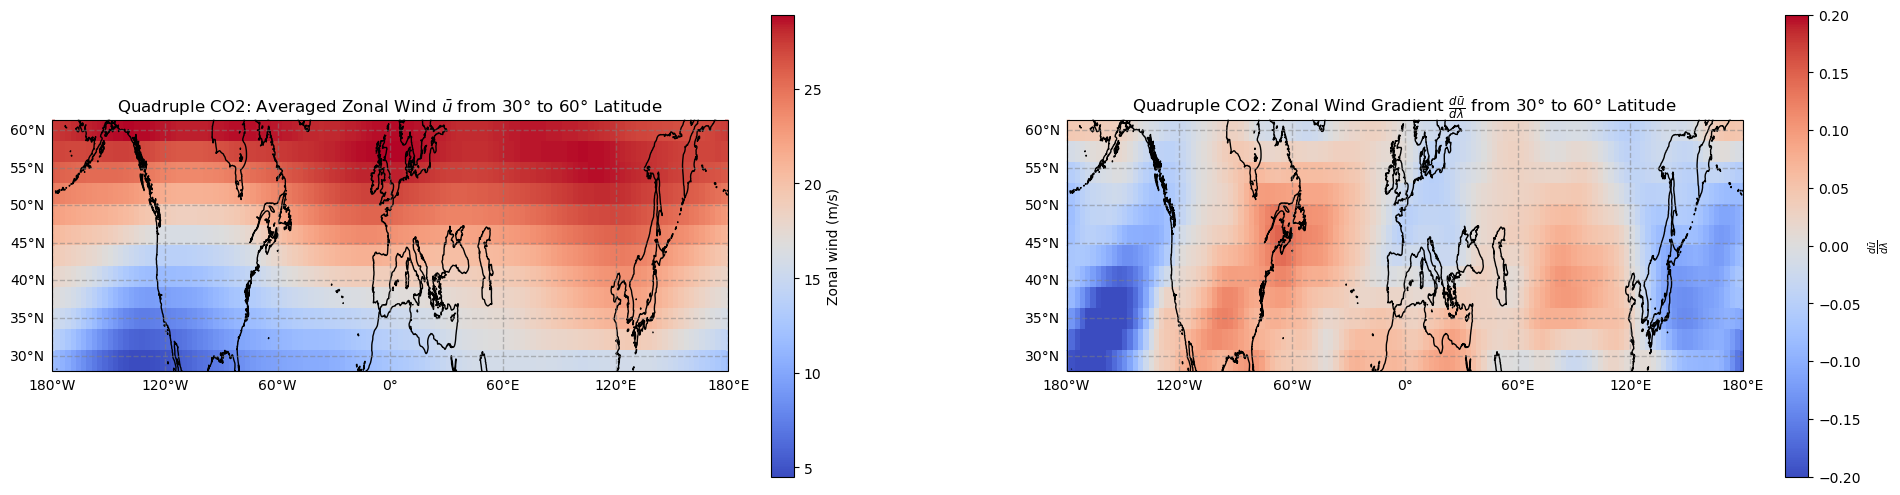

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Path to the NetCDF file
file_path = '/scratch/negishi/yan481/3004/quadruple/25/atmos_4xdaily.nc'

# Load the NetCDF file with decode_times set to False
dataset = xr.open_dataset(file_path, decode_times=False)

# Select the 'ucomp' variable
ucomp = dataset['ucomp']

# Filter for latitudes between 29.3 and 60 degrees
filtered_ucomp = ucomp.where((ucomp.lat >= 29.3) & (ucomp.lat <= 60), drop=True)

# Compute the time average of the filtered ucomp
time_avg_ucomp = filtered_ucomp.mean(dim='time').mean(dim='pfull')

# Wrapping around for circular boundary condition at the 0th/360th meridian
wrapped_ucomp = xr.concat([time_avg_ucomp, time_avg_ucomp.isel(lon=0)], dim='lon')

# Calculate du/dlon considering the wrap
delta_lon = np.diff(wrapped_ucomp.lon)[0]  # Assuming uniform spacing
du_dlon = wrapped_ucomp.diff(dim='lon') / delta_lon

# Determine the maximum absolute value for symmetric coloring around zero
# max_dudlon = np.abs(du_dlon.values).max()
max_dudlon = 0.2

# Set up the plot with a map projection
fig, ax = plt.subplots(1, 2, figsize=(24, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# First subplot for time-averaged ucomp
ax[0].coastlines()
lons, lats = np.meshgrid(time_avg_ucomp.lon.values, time_avg_ucomp.lat.values)
heatmap1 = ax[0].pcolormesh(lons, lats, time_avg_ucomp.values, transform=ccrs.PlateCarree(), cmap='coolwarm')
plt.colorbar(heatmap1, ax=ax[0], orientation='vertical', label='Zonal wind (m/s)')
ax[0].set_title(r'Quadruple CO2: Averaged Zonal Wind $\bar{u}$ from 30° to 60° Latitude')
ax[0].set_aspect(4) 

# Second subplot for du/dlon, with colormap centered at zero
ax[1].coastlines()
lons_gradient, lats_gradient = np.meshgrid(time_avg_ucomp.lon.values[:], time_avg_ucomp.lat.values)
heatmap2 = ax[1].pcolormesh(lons_gradient, lats_gradient, du_dlon.values, vmin=-max_dudlon, vmax=max_dudlon,
                            transform=ccrs.PlateCarree(), cmap='coolwarm')
plt.colorbar(heatmap2, ax=ax[1], orientation='vertical', label=r'$\frac{d\bar{u}}{d\lambda}$')
ax[1].set_title(r'Quadruple CO2: Zonal Wind Gradient $\frac{d\bar{u}}{d\lambda}$ from 30° to 60° Latitude')
ax[1].set_aspect(4) 

for axis in ax:
    gl = axis.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

plt.show()


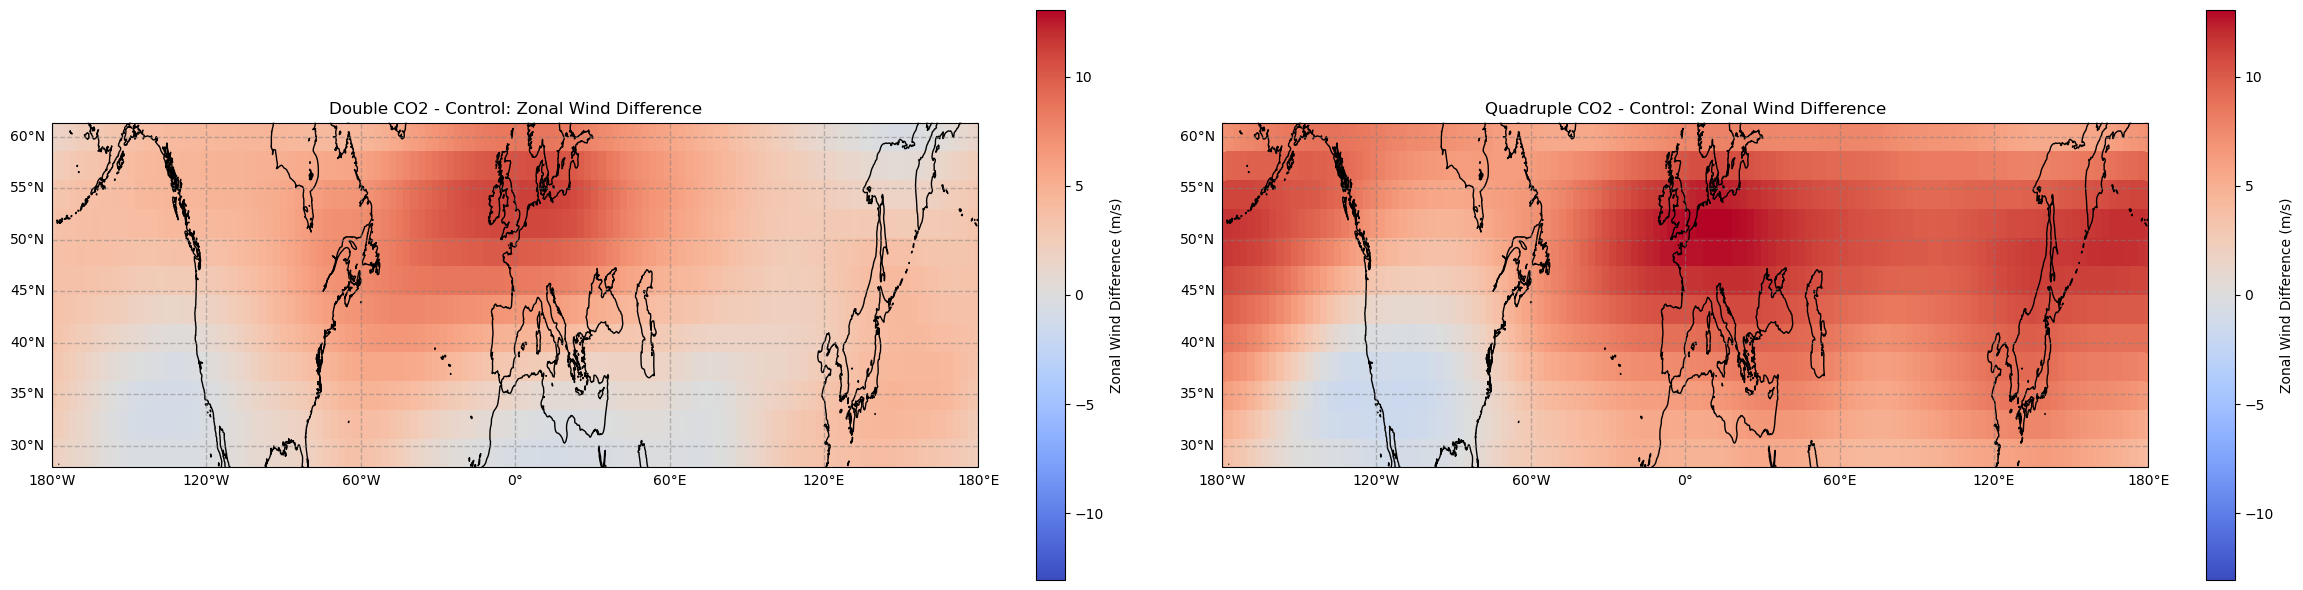

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def compute_average_zonal_wind(file_path):
    # Load the NetCDF file
    dataset = xr.open_dataset(file_path, decode_times=False)

    # Select the 'ucomp' variable and filter for latitudes
    ucomp = dataset['ucomp'].where((dataset['ucomp'].lat >= 29.3) & (dataset['ucomp'].lat <= 60), drop=True)

    # Compute the time and pressure average of the filtered ucomp
    time_avg_ucomp = ucomp.mean(dim='time').mean(dim='pfull')

    return time_avg_ucomp

# Define file paths
control_path = '/scratch/negishi/yan481/3004/control/25/atmos_4xdaily.nc'
double_co2_path = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc'
quad_co2_path = '/scratch/negishi/yan481/3004/quadruple/25/atmos_4xdaily.nc'

# Compute average zonal winds
control_avg_ucomp = compute_average_zonal_wind(control_path)
double_co2_avg_ucomp = compute_average_zonal_wind(double_co2_path)
quad_co2_avg_ucomp = compute_average_zonal_wind(quad_co2_path)

# Compute differences
double_minus_control_ucomp = double_co2_avg_ucomp - control_avg_ucomp
quad_minus_control_ucomp = quad_co2_avg_ucomp - control_avg_ucomp

# Determine the maximum absolute value for symmetric coloring around zero
max_ucomp_diff = max(np.abs(double_minus_control_ucomp.values).max(), np.abs(quad_minus_control_ucomp.values).max())

# Set up the plot with a map projection
fig, ax = plt.subplots(1, 2, figsize=(24, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Subplot for Double CO2 - Control zonal wind difference
ax[0].coastlines()
lons, lats = np.meshgrid(control_avg_ucomp.lon.values, control_avg_ucomp.lat.values)
heatmap1 = ax[0].pcolormesh(lons, lats, double_minus_control_ucomp.values, vmin=-max_ucomp_diff, vmax=max_ucomp_diff,
                            transform=ccrs.PlateCarree(), cmap='coolwarm')
plt.colorbar(heatmap1, ax=ax[0], orientation='vertical', label='Zonal Wind Difference (m/s)')
ax[0].set_title(r'Double CO2 - Control: Zonal Wind Difference')
ax[0].set_aspect(4) 

# Subplot for Quadruple CO2 - Control zonal wind difference
ax[1].coastlines()
heatmap2 = ax[1].pcolormesh(lons, lats, quad_minus_control_ucomp.values, vmin=-max_ucomp_diff, vmax=max_ucomp_diff,
                            transform=ccrs.PlateCarree(), cmap='coolwarm')
plt.colorbar(heatmap2, ax=ax[1], orientation='vertical', label='Zonal Wind Difference (m/s)')
ax[1].set_title(r'Quadruple CO2 - Control: Zonal Wind Difference')
ax[1].set_aspect(4) 

# Setting up gridlines
for axis in ax:
    gl = axis.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

plt.tight_layout()  # Adjust layout so that plots do not overlap
plt.show()


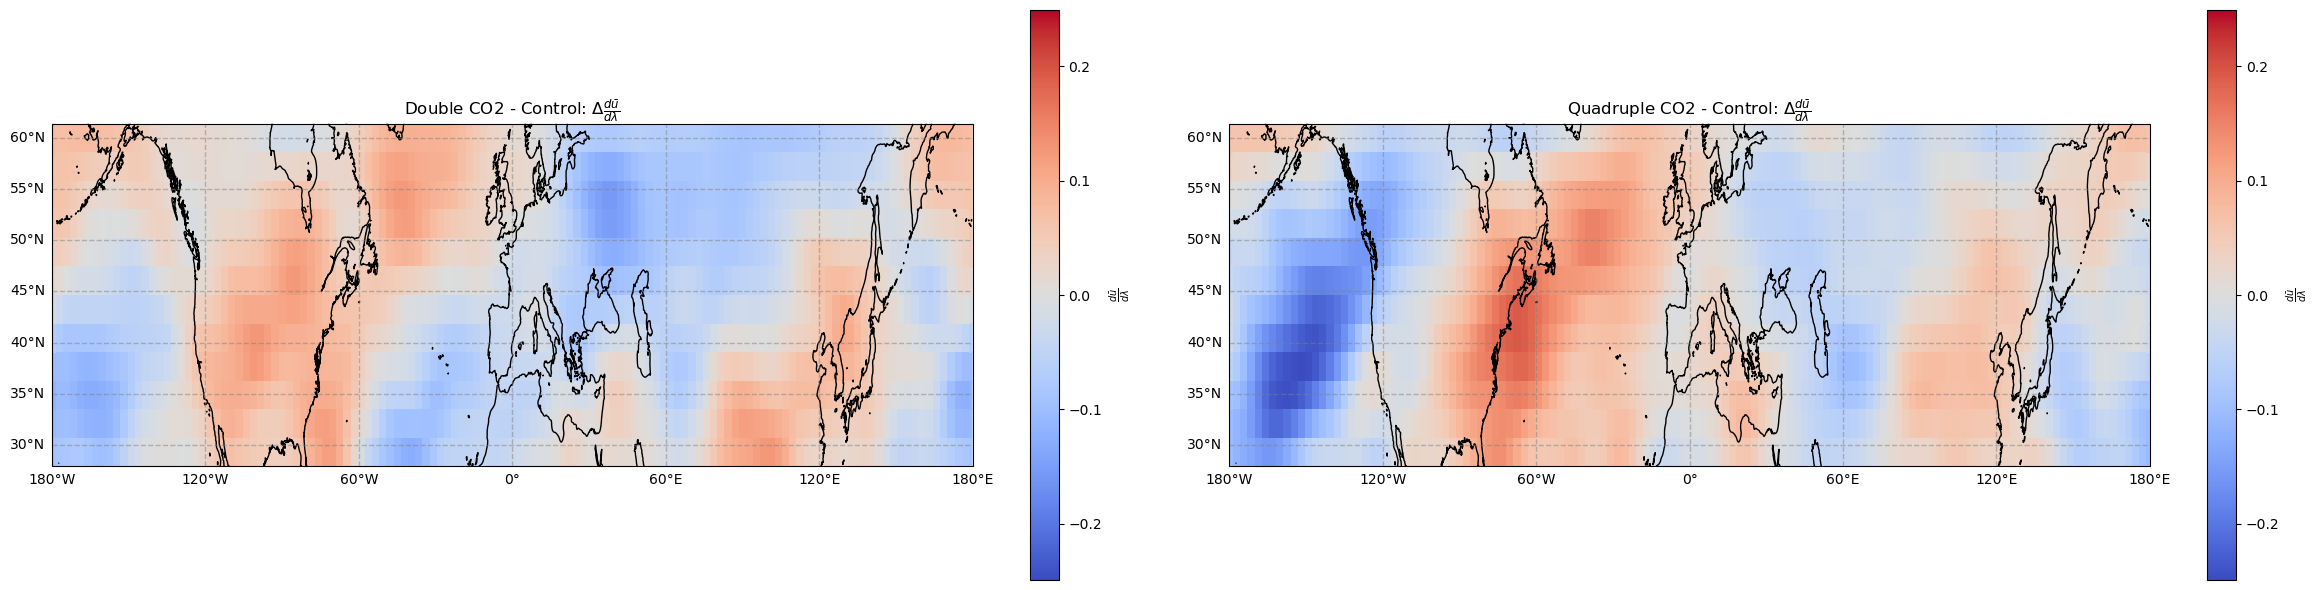

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def compute_gradient(file_path):
    # Load the NetCDF file
    dataset = xr.open_dataset(file_path, decode_times=False)

    # Select the 'ucomp' variable and filter for latitudes
    ucomp = dataset['ucomp'].where((dataset['ucomp'].lat >= 29.3) & (dataset['ucomp'].lat <= 60), drop=True)

    # Compute the time and pressure average of the filtered ucomp
    time_avg_ucomp = ucomp.mean(dim='time').mean(dim='pfull')

    # Wrapping around for circular boundary condition
    wrapped_ucomp = xr.concat([time_avg_ucomp, time_avg_ucomp.isel(lon=0)], dim='lon')

    # Calculate du/dlon considering the wrap
    delta_lon = np.diff(wrapped_ucomp.lon)[0]  # Assuming uniform spacing
    du_dlon = wrapped_ucomp.diff(dim='lon') / delta_lon

    return du_dlon

# Define file paths
control_path = '/scratch/negishi/yan481/3004/control/25/atmos_4xdaily.nc'
double_co2_path = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc'
quad_co2_path = '/scratch/negishi/yan481/3004/quadruple/25/atmos_4xdaily.nc'

# Compute gradients
control_gradient = compute_gradient(control_path)
double_co2_gradient = compute_gradient(double_co2_path)
quad_co2_gradient = compute_gradient(quad_co2_path)

# Compute differences
double_minus_control = double_co2_gradient - control_gradient
quad_minus_control = quad_co2_gradient - control_gradient

# Determine the maximum absolute value for symmetric coloring around zero
max_dudlon = max(np.abs(double_minus_control.values).max(), np.abs(quad_minus_control.values).max())

# Set up the plot with a map projection
fig, ax = plt.subplots(1, 2, figsize=(24, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Subplot for Double CO2 - Control
ax[0].coastlines()
lons, lats = np.meshgrid(double_minus_control.lon.values, double_minus_control.lat.values)
heatmap1 = ax[0].pcolormesh(lons, lats, double_minus_control.values, vmin=-max_dudlon, vmax=max_dudlon,
                            transform=ccrs.PlateCarree(), cmap='coolwarm')
plt.colorbar(heatmap1, ax=ax[0], orientation='vertical', label=r'$\frac{d\bar{u}}{d\lambda}$')
ax[0].set_title(r'Double CO2 - Control: $\Delta \frac{d\bar{u}}{d\lambda}$')
ax[0].set_aspect(4) 

# Subplot for Quadruple CO2 - Control
ax[1].coastlines()
lons_quad, lats_quad = np.meshgrid(quad_minus_control.lon.values, quad_minus_control.lat.values)
heatmap2 = ax[1].pcolormesh(lons_quad, lats_quad, quad_minus_control.values, vmin=-max_dudlon, vmax=max_dudlon,
                            transform=ccrs.PlateCarree(), cmap='coolwarm')
plt.colorbar(heatmap2, ax=ax[1], orientation='vertical', label=r'$\frac{d\bar{u}}{d\lambda}$')
ax[1].set_title(r'Quadruple CO2 - Control: $\Delta \frac{d\bar{u}}{d\lambda}$')
ax[1].set_aspect(4) 

# Setting up gridlines
for axis in ax:
    gl = axis.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

plt.tight_layout()  # Adjust layout so that plots do not overlap
plt.show()
